## Jigsaw - Agile Community Rules Classification
*This project involves building a **binary classifier** that predicts whether a Reddit comment violates a specific subreddit rule. Given the diverse and nuanced moderation guidelines across subreddits, the task focuses on applying machine learning to real-world content moderation.*


### Overview

#### - Problem definition
Create a binary classifier that predicts whether a Reddit comment broke a specific rule.

#### - Data
The dataset consists of historical, unlabeled Reddit comments, accompanied by a set of hypothetical rules derived from actual subreddit guidelines. A small labeled development set is provided for training or few-shot learning. The goal is to predict if a comment breaks any of the given rules, with submissions evaluated on their ability to generalize across different community norms.

**train.csv** - the training dataset
- body - the text of the comment
- rule - the rule the comment is judged to be in violation of
- subreddit - the forum the comment was made in
- positive_example_{1,2} - examples of comments that violate the rule
- negative_example_{1,2} - examples of comments that do not violate the rule
- rule_violation - the binary target

**test.csv** - the test dataset; your objective is to predict the probability of a rule_violation. NOTE: The test dataset contains additional rules that are not seen in the in the training data, so models must be flexible to unseen rules.

**sample_submission.csv** - a sample submission file in the correct format.

#### - Evaluation metric
> Submissions are evaluated on column-averaged AUC.

### Libraries

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import accuracy_score 
from sklearn.svm import LinearSVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
import optuna as opt
import xgboost as xgb
import catboost as cat
%matplotlib inline

### Data Analysis

In [3]:
# import data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [147]:
# view train data
train.sample(frac=.003)

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
1050,1050,"Even though that's not OP's tree, it sounds li...",No legal advice: Do not offer or request legal...,DIY,You don't have to give a boyfriend notice if h...,"This is illegal, 30 day notice minimum is requ...","LPT piratebay, transmission, vpn. Get the musi...","Short term it was amazing, knowing I had ended...",1
711,711,SD EN Stream | [Stable Quality](http://firstro...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,porn video http://y2u.be/..https://bam.bz/OY *...,**Dortmund vs Real Madrid Live Stream**\n\n**<...,Check out the rest at: https://medium.com/the-...,[This mixtape is lit FAM!](https://beholdthear...,0
293,293,"NAL but since they do own those pictures, and ...",No legal advice: Do not offer or request legal...,legaladvice,1. Just assuming your husbands rights were rea...,"Sue your father, destroy your relationship wit...",Can I slam them in a door? \n\nCan I kick them...,bestway is to sell to local ppl from ur countr...,1
477,477,>Because you're not supposed to sexually penet...,No legal advice: Do not offer or request legal...,news,Is it possible for a father to give up visitat...,You could take a chance and skip taxes for tha...,"Simple solution, if forced to perform such sur...",I actually seriously mutilated someones nipple...,0
1950,1950,Must Watch : https://www.youtube.com/watch?v=d...,"No Advertising: Spam, referral links, unsolici...",videos,(US only) Save on 20% on high capacity 2000...,strange things with her that slut hole gon...,try the package made available by [ArenaVision...,SD/HD/Mobile GG.GG/42toi\n\n\nGG.GG/42toi\n\n\...,0
269,269,/r/krat0m <-subscribe for free kilo of strong ...,"No Advertising: Spam, referral links, unsolici...",gaming,240K if ur interested \nhttps://steamcommunity...,call whores watch for you herein http://onj.me...,This is what I used to jailbreak: http://iemul...,[Arsenal vs Ludogorets HD Stream](http://strea...,0


Note: The rule could be feature engineerd to have like for example No_Advertising_Spam, No_Advertising_referral_links ...

In [146]:
# view test data
test.sample(frac=.5)

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
0,2029,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,"No Advertising: Spam, referral links, unsolici...",hiphopheads,"Hey, guys, just wanted to drop in and invite y...",Cum Swallowing Hottie Katrina Kaif Cartoon Xvi...,SD Stream Eng - [Chelsea TV USA](http://soccer...,HD Streams: |[ENG HD Stoke vs Manchester Unite...
1,2030,Make your life comfortable. Get up to 15% Disc...,No legal advice: Do not offer or request legal...,AskReddit,Get a lawyer and get the security camera foota...,That isn't drastic. You tried reaching out to ...,So what are you going to do with the insurance...,It's just for Austria & Germany. If you still ...
9,2038,Free paypal cards here!! https://www.pointspri...,"No Advertising: Spam, referral links, unsolici...",pics,she will come your home open her legs with an...,Old and young your girl-next-door make sex wi...,"i think the conjuring 2 is not bad movie ,The...","wow, she's so beautyful\n>[Sakura Vietnam](htt..."
3,2032,watch hooters best therein http://clickan...,"No Advertising: Spam, referral links, unsolici...",personalfinance,"Earn 50,000 bonus points with Chase Sapphire P...","Cool, front page! I made this print along with...",[Full HD Movie Online Free](http://www.flickma...,* Karambit Black Pearl\n* 0.02137822 Float (un...
7,2036,[This mixtape is lit FAM!](https://beholdthear...,"No Advertising: Spam, referral links, unsolici...",BlackPeopleTwitter,watch good one hooters there http://https://x5...,bad pussies waiting for you herein http://gour...,[Full HD Movie Online Free](http://www.flickma...,* Computers :http://livematchstreamz.blogspot....


In [150]:
# check dimension of train and test data
train.shape, test.shape

((2029, 9), (10, 8))

There are 2029 rows/samples and 9 columns/variables in the train dataset. While the test dataset have 10 rows and 8 columns

In [161]:
print(f'{list(train.columns)} \n {list(test.columns)}')

['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2', 'rule_violation'] 
 ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2']


Both train and test datasets have same features arranged in same order.

#### Data Wrangling
> Assess data and make sure it is ready for ML training

In [164]:
# descriptive statistics on train dataset 
train[:100].describe

<bound method NDFrame.describe of     row_id                                               body  \
0        0  Banks don't want you to know this! Click here ...   
1        1  SD Stream [ ENG Link 1] (http://www.sportsstre...   
2        2  Lol. Try appealing the ban and say you won't d...   
3        3  she will come your home open her legs with  an...   
4        4  code free tyrande --->>> [Imgur](http://i.imgu...   
..     ...                                                ...   
95      95  Use my code for Csgoroll.com  :)\nFor free $0....   
96      96  Read Tom Clancy's, WITHOUT REMORSE, you will k...   
97      97  hello, who love watching the movies for free ?...   
98      98  Should be said as well: Don't accept any offer...   
99      99  Shop at Golden Nugget Jewelers for Engagement ...   

                                                 rule        subreddit  \
0   No Advertising: Spam, referral links, unsolici...       Futurology   
1   No Advertising: Spam, referral li

Doesn't give a good output

In [166]:
# let's try .info() 
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              2029 non-null   int64 
 1   body                2029 non-null   object
 2   rule                2029 non-null   object
 3   subreddit           2029 non-null   object
 4   positive_example_1  2029 non-null   object
 5   positive_example_2  2029 non-null   object
 6   negative_example_1  2029 non-null   object
 7   negative_example_2  2029 non-null   object
 8   rule_violation      2029 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 142.8+ KB


There 7 non-numerical columns

In [171]:
# confirm non-numeric columns
for name,content in train.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(name)

body
rule
subreddit
positive_example_1
positive_example_2
negative_example_1
negative_example_2


In [167]:
# confirm that there are no missing values 
train.isna().sum()

row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
rule_violation        0
dtype: int64

- There are no missing values in the train dataset

In [172]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              10 non-null     int64 
 1   body                10 non-null     object
 2   rule                10 non-null     object
 3   subreddit           10 non-null     object
 4   positive_example_1  10 non-null     object
 5   positive_example_2  10 non-null     object
 6   negative_example_1  10 non-null     object
 7   negative_example_2  10 non-null     object
dtypes: int64(1), object(7)
memory usage: 772.0+ bytes


So far, the main fix required to be done on the data before proceeding to EDA and Modelling is to convert non numerical features to numerical

<Axes: >

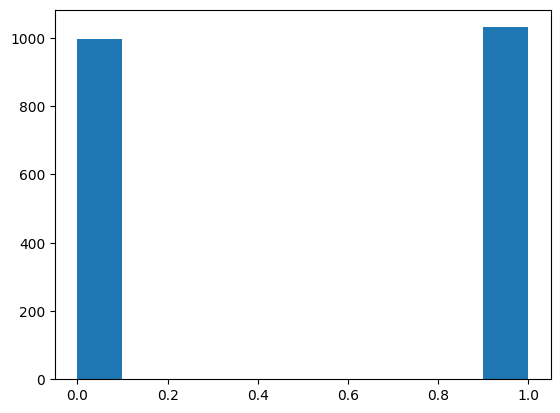

In [179]:
# check for data imbalance across `rule violation` column
train['rule_violation'].hist(grid=False);

In [176]:
train['rule_violation'].value_counts(normalize=True)

rule_violation
1    0.508132
0    0.491868
Name: proportion, dtype: float64

Data seem balanced

#### Data cleanup

#### EDA (Exploratory Data Analysis)
> Explore relevant relationships that exists amongst several features

### Modelling

In [ ]:
# make copy of cleaned data

#### - Hyper-parameter tuning

#### - Fit best model

#### - Pre-process test data (optional)

#### - Feature importance

### Deployment

### Experiments (optional)

### Conclusion